# Implementación desde 0 del algoritmo k-Nearest Neighbors

In [1]:
# Bibliotecas
import random
from sklearn import datasets

## Cargando los datos

In [2]:
# Se especifican las rutas al conjunto de entrenamiento y prueba
train_file = "Datasets/Datos-S-Entrena.txt"
test_file = "Datasets/S-Prueba.txt"

In [3]:
# Función que recibe un archivo de texto y retorna 
# los atributos y la clase en una tupla (lista, int)

def load_data(file_object):
    dataset = list()
    for line in file_object:
        temp_list = [float(x) for x in line.split(",")]
        attribs = temp_list[:len(temp_list)-2]
        category = int(temp_list[len(temp_list)-1])
        
        # Apendizando el ejemplo
        dataset.append((attribs, category))
        
    return dataset

In [4]:
# Cargando los ejemplos (líneas) de entrenamiento y prueba
train_f = open(train_file, "r")
test_f = open(test_file, "r")

# Cargando el conjunto de entrenamiento
train_data = load_data(train_f)
print("Cantidad de ejemplos de entrenamiento: ", len(train_data))
print("Cantidad de atributos:", len(train_data[0][0]))
print("Ejemplo de entrenamiento: ", train_data[0])

# Cargando el conjunto de prueba
test_data = load_data(test_f)
print("\n\nCantidad de ejemplos de prueba: ", len(test_data))
print("Cantidad de atributos:", len(test_data[0][0]))
print("Ejemplo de entrenamiento: ", test_data[0])

Cantidad de ejemplos de entrenamiento:  397
Cantidad de atributos: 18
Ejemplo de entrenamiento:  ([140.0, 125.0, 0.0, 0.0, 0.0, 0.2777779, 0.06296301, 0.66666675, 0.31111118, 6.185185, 7.3333335, 7.6666665, 3.5555556, 3.4444444, 4.4444447, -7.888889, 7.7777777, 0.5456349], 0)


Cantidad de ejemplos de prueba:  23
Cantidad de atributos: 18
Ejemplo de entrenamiento:  ([242.0, 65.0, 0.0, 0.0, 0.0, 0.5555553, 0.27216578, 1.0, 0.42163682, 8.925926, 6.111111, 14.333333, 6.3333335, -8.444445, 16.222221, -7.7777777, 14.333333, 0.5834605], 6)


In [5]:
# Revisando uniformidad de los datos
def check_attribs(data):
    first_len = len(data[0][0])
    for i, sample in enumerate(data):
        if len(sample[0]) != first_len:
            return ("Muestra %d tiene %d atributos." %(i, len(sample[0])))
    print("Los datos son uniformes.")        
    
    
check_attribs(train_data)
check_attribs(test_data)

Los datos son uniformes.
Los datos son uniformes.


## Métricas de distancia

### Distancia Minkowski

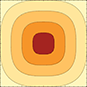 
Figura para $p=3$

La distancia Minkowski es la forma generalizada para la norma $L_p$ de la diferencia. 

$d_{\mathbf{p}} : (x, y) \mapsto \|x-y\|_p = \bigg(\sum_{i=1}^{n} |x_i-y_i|^p\bigg)^\frac{1}{p}$

In [6]:
# Distancia Minkowski
def minkowski(vector1, vector2, p):
    distancia = 0.0
    for i in range(len(vector1)-1):
        distancia += abs(vector1[i] - vector2[i])**p
    
    return (distancia)**(1/p)

# Ejemplo
print(minkowski(train_data[0][0], train_data[0][0], 3))
print(minkowski(train_data[0][0], train_data[1][0], 3))

0.0
48.07492579003488


### Distancia Manhattan o L1

También se conoce como Sum of Absolute Difference (SAD). Es la norma $L_1$ de la diferencia. Es un caso especial de la distancia Minkowski, en donde $p=1$.

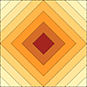

$d_{\mathbf{SAD}} : (x, y) \mapsto \|x-y\|_1 = \sum_{i=1}^{n} |x_i-y_i|$

In [7]:
# Distancia Manhattan o L1
def sad(vector1, vector2):
    return minkowski(vector1, vector2, 1)

# Ejemplo
print(sad(train_data[0][0], train_data[0][0]))
print(sad(train_data[0][0], train_data[1][0]))

0.0
62.362964063999996


### Distancia Euclidiana o norma L2

Se calcula a partir de Sum of Squared Difference (SSD). Es la norma $L_2$ de la diferencia. Es un caso especial de la distancia Minkowski, en donde $p=2$.

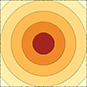

$d_{\mathbf{2}} : (x, y) \mapsto \|x-y\|_2 = \sqrt{d_{\mathbf{SSD}}} = \sqrt{\sum_{i=1}^{n} (x_i-y_i)^2}$

In [8]:
# Distancia Euclidiana o norma L2
def euclidean(vector1, vector2):
    return minkowski(vector1, vector2, 2)

# Ejemplo
print(euclidean(train_data[0][0], train_data[0][0]))
print(euclidean(train_data[0][0], train_data[1][0]))

0.0
48.721436592119595


### Distancia Chebyshev

Es la norma $L_{\infty}$ de la diferencia. Es un caso especial de la distancia Minkowski, en donde $p=\infty$. También se le conoce como distancia de tablero de ajedrez.

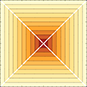

$d_{\mathbf{\infty}} : (x, y) \mapsto \|x-y\|_\infty = \lim_{p \rightarrow \infty}\bigg(\sum_{i=1}^{n} |x_i-y_i|^p\bigg)^\frac{1}{p} = \max_{i} |x_i-y_i|$

In [9]:
# Distancia Chebyshev
def chebyshev(vector1, vector2):
    differences = []
    for i in range(len(vector1)-1):
        differences.append(abs(vector1[i] - vector2[i]))
    
    return max(differences)

# Ejemplo
print(chebyshev(train_data[0][0], train_data[0][0]))
print(chebyshev(train_data[0][0], train_data[1][0]))

0.0
48.0


### Función que calcula las distancias de un punto a todos los otros


In [10]:
def euclidean_point(point, points):
    distances = list()
    for element in points:
        distances.append((euclidean(point, element[0]), element[1], element[0]))
        
    return distances 

def minkowski_point(point, points, p):
    distances = list()
    for element in points:
        distances.append((minkowski(point, element[0], p), element[1], element[0]))
        
    return distances

def chebyshev_point(point, points):
    distances = list()
    for element in points:
        distances.append((chebyshev(point, element[0]), element[1], element[0]))
        
    return distances

def manhattan_point(point, points):
    distances = list()
    for element in points:
        distances.append((sad(point, element[0]), element[1], element[0]))
        
    return distances

# Función que calcula distancias de un punto a los restantes
def point_to_points(point, points, distance):
    if distance == 'euclidean':
        return euclidean_point(point, points)
    elif distance == 'minkowski':
        p = int(input("Valor p: "))
        return minkowski_point(point, points, p)
    elif distance == 'manhattan':
        return manhattan_point(point, points)
    elif distance == 'chebyshev':
        return chebyshev_point(point, points)
    else:
        return "ERROR: Elige una función de distancia válida."
    

# Pruebas
print(point_to_points(train_data[0][0], train_data, 'euclidean'))

[(0.0, 0, [140.0, 125.0, 0.0, 0.0, 0.0, 0.2777779, 0.06296301, 0.66666675, 0.31111118, 6.185185, 7.3333335, 7.6666665, 3.5555556, 3.4444444, 4.4444447, -7.888889, 7.7777777, 0.5456349]), (48.721436592119595, 0, [188.0, 133.0, 0.0, 0.0, 0.0, 0.33333334, 0.26666674, 0.5, 0.077777736, 6.6666665, 8.333334, 7.7777777, 3.8888888, 5.0, 3.3333333, -8.333333, 8.444445, 0.53858024]), (37.72863871143197, 0, [105.0, 139.0, 0.0, 0.0, 0.0, 0.27777782, 0.107407436, 0.83333325, 0.52222216, 6.111111, 7.5555553, 7.2222223, 3.5555556, 4.3333335, 3.3333333, -7.6666665, 7.5555553, 0.5326279]), (106.74644136109504, 0, [34.0, 137.0, 0.0, 0.0, 0.0, 0.5000002, 0.16666673, 1.111111, 0.47407418, 5.851852, 7.7777777, 6.4444447, 3.3333333, 5.7777777, 1.7777778, -7.5555553, 7.7777777, 0.57363313]), (101.97075080225294, 0, [39.0, 111.0, 0.0, 0.0, 0.0, 0.72222227, 0.37407416, 0.8888889, 0.4296295, 6.037037, 7.0, 7.6666665, 3.4444444, 2.8888888, 4.888889, -7.7777777, 7.888889, 0.56291884]), (124.05296205414237, 0, [16

## Calculando los vecinos más cercanos a un nuevo punto

La implementación de este algoritmo está basada en el siguiente pseudocódigo: 

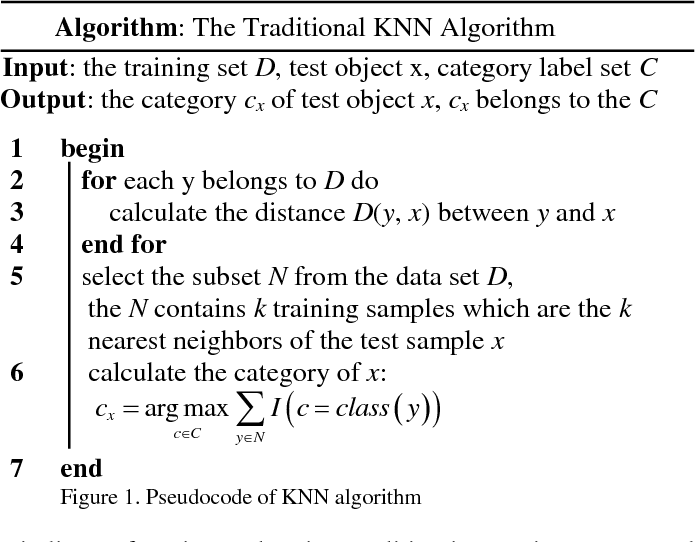

In [11]:
# Función que retorna los k vecinos más cercanos al nuevo punto
def k_neighbors(new_point, dataset, k, metric):
    from statistics import mode
    # Obteniendo las distancias
    distances = point_to_points(new_point, dataset, metric)
    distances.sort(key=lambda tup: tup[0])
    
    # Obteniendo los k mas cercanos
    neighbors = list()
    for i in range(k):
        neighbors.append(distances[i][1])
    
    return neighbors, mode(neighbors), distances[:k]


# Función que predice las clases para todas las muestras
# de un conjunto nuevo
def classify(train_data, test_data, k, metric):
    xy = [-1, -1]
    predicted = list()
    for sample in test_data:
        xy[0] = k_neighbors(sample[0], train_data, k, metric)[1]
        xy[1] = sample[1]
        predicted.append((xy[0], xy[1]))
        
    return predicted

# Función que calcula la precisión
def accuracy(predictions, verbose):
    total_samples = len(predictions)
    correct = 0
    
    for i, pair in enumerate(predictions):
        if verbose: 
            print("%d: Clase estimada: %d | Clase real: %d" %(i+1, pair[0], pair[1]))
            
        if pair[0] == pair[1]:
            correct += 1
    return correct / total_samples
        

predictions = classify(train_data, test_data, k=3, metric='euclidean')
print("Exactitud del clasificador: ", str(accuracy(predictions, True)*100)+"%")

1: Clase estimada: 6 | Clase real: 6
2: Clase estimada: 6 | Clase real: 6
3: Clase estimada: 4 | Clase real: 4
4: Clase estimada: 4 | Clase real: 4
5: Clase estimada: 4 | Clase real: 4
6: Clase estimada: 2 | Clase real: 2
7: Clase estimada: 2 | Clase real: 2
8: Clase estimada: 1 | Clase real: 2
9: Clase estimada: 2 | Clase real: 2
10: Clase estimada: 4 | Clase real: 4
11: Clase estimada: 3 | Clase real: 3
12: Clase estimada: 3 | Clase real: 3
13: Clase estimada: 3 | Clase real: 3
14: Clase estimada: 0 | Clase real: 0
15: Clase estimada: 0 | Clase real: 0
16: Clase estimada: 0 | Clase real: 0
17: Clase estimada: 6 | Clase real: 0
18: Clase estimada: 5 | Clase real: 5
19: Clase estimada: 5 | Clase real: 5
20: Clase estimada: 5 | Clase real: 5
21: Clase estimada: 1 | Clase real: 1
22: Clase estimada: 1 | Clase real: 1
23: Clase estimada: 1 | Clase real: 1
Exactitud del clasificador:  91.30434782608695%


## Funciones necesarias para evaluar con k-fold cross validation

In [12]:
# Función que divide el dataset en k folds
def get_k_folds(k, data):
    size = len(data)
    fold_size = size // k
    k_folds = list()
    print("Diviendo los datos en %d folds de tamaño %d" %(k, fold_size))
    
    begin = 0
    end = fold_size
    for i in range(k):
        k_folds.append(data[begin:end])
        begin += fold_size
        end += fold_size
    
    return k_folds
    
# Función que calcula y retorna la precision para los k_folds
def k_fold_cross_val(data, n_folds, k_neighbors, metric):
    # Obteniendo los k_folds
    k_folds = get_k_folds(n_folds, data)
    
    # Realizando las predicciones
    accuracies = []
    for i in range(n_folds):
        test = k_folds[i]
        train = [sample for n,fold in enumerate(k_folds) for sample in fold if n != i]
        predictions = classify(train, test, k_neighbors, metric)
        accuracies.append(accuracy(predictions, False))
    
    return accuracies

# Función que formatea los datasets de sklearn
def convert_dataset(sklearn_dataset):
    # Convirtiendo al formato que recibe nuestra implementación
    data = sklearn_dataset[0]
    targets = sklearn_dataset[1]

    formated_dataset = []
    for i in range(len(data)):
        formated_dataset.append((list(data[i]), targets[i]))
    
    return formated_dataset

### Evaluación Cross-Validation con varios datasets

##### Dataset de entrenamiento y prueba de la materia

In [53]:
# Evaluando implementación con el dataset de la materia
# Se mezcla el conjunto de entrenamiento con el de prueba
train_test_data = train_data + test_data
random.shuffle(train_test_data)

print("Cantidad de ejemplos en el dataset: ", len(train_test_data))
print("Cantidad de atributos:", len(train_test_data[0][0]), "\n")
#print("Ejemplo de instancia: ", train_test_data[0])

k_fold_scores = k_fold_cross_val(train_test_data, 10, 2, 'euclidean')
print("Promedio de precisión en k-folds:", sum(k_fold_scores)/len(k_fold_scores))

Cantidad de ejemplos en el dataset:  420
Cantidad de atributos: 18 

Diviendo los datos en 10 folds de tamaño 42
Promedio de precisión en k-folds: 0.9238095238095239


##### Dataset Iris, disponible en el banco de datasets de sklearn

In [71]:
# Obteniendo y transformando el dataset
formated_iris = convert_dataset(datasets.load_iris(return_X_y=True))
random.shuffle(formated_iris)

In [84]:
# Evaluando la implementación con el dataset Iris
# Visualizando datos del dataset
print("Cantidad de ejemplos en el dataset: ", len(formated_iris))
print("Cantidad de atributos:", len(formated_iris[0][0]), "\n")

# Midiendo desempeño de la implementación con k-folds
iris_k_fold_scores = k_fold_cross_val(formated_iris, 10, 15, 'euclidean')
print("Promedio de precisión en k-folds:", sum(iris_k_fold_scores)/len(iris_k_fold_scores))

Cantidad de ejemplos en el dataset:  150
Cantidad de atributos: 4 

Diviendo los datos en 10 folds de tamaño 15
Promedio de precisión en k-folds: 0.9533333333333334


##### Dataset Wine, disponible en el banco de datasets de sklearn

In [85]:
# Obteniendo y transformando el dataset
formated_wine = convert_dataset(datasets.load_wine(return_X_y=True))
random.shuffle(formated_wine)

In [102]:
# Evaluando la implementación con el dataset Wine
# Visualizando datos del dataset
print("Cantidad de ejemplos en el dataset: ", len(formated_wine))
print("Cantidad de atributos:", len(formated_wine[0][0]), "\n")

# Midiendo desempeño de la implementación con k-folds
wine_k_fold_scores = k_fold_cross_val(formated_wine, 10, 3, 'euclidean')
print("Promedio de precisión en k-folds:", sum(wine_k_fold_scores)/len(wine_k_fold_scores))

Cantidad de ejemplos en el dataset:  178
Cantidad de atributos: 13 

Diviendo los datos en 10 folds de tamaño 17
Promedio de precisión en k-folds: 0.8764705882352942


##### Dataset Breast Cancer, disponible en el banco de datasets de sklearn

In [103]:
# Obteniendo y transformando el dataset
formated_breast = convert_dataset(datasets.load_breast_cancer(return_X_y=True))
random.shuffle(formated_breast)

In [115]:
# Evaluando la implementación con el dataset Breast Cancer

# Visualizando datos del dataset
print("Cantidad de ejemplos en el dataset: ", len(formated_breast))
print("Cantidad de atributos:", len(formated_breast[0][0]), "\n")

# Midiendo desempeño de la implementación con k-folds
cancer_k_fold_scores = k_fold_cross_val(formated_breast, 10, 10, 'euclidean')
print("Promedio de precisión en k-folds:", sum(cancer_k_fold_scores)/len(cancer_k_fold_scores))

Cantidad de ejemplos en el dataset:  569
Cantidad de atributos: 30 

Diviendo los datos en 10 folds de tamaño 56
Promedio de precisión en k-folds: 0.9410714285714284


##### Dataset Digits, disponible en el banco de datasets de sklearn

In [116]:
# Obteniendo y transformando el dataset
formated_digits = convert_dataset(datasets.load_digits(return_X_y=True))
random.shuffle(formated_digits)

In [117]:
# Evaluando la implementación con el dataset Digits

# Visualizando datos del dataset
print("Cantidad de ejemplos en el dataset: ", len(formated_digits))
print("Cantidad de atributos:", len(formated_digits[0][0]), "\n")

# Midiendo desempeño de la implementación con k-folds
digits_k_fold_scores = k_fold_cross_val(formated_digits, 10, 2, 'euclidean')
print("Promedio de precisión en k-folds:", sum(digits_k_fold_scores)/len(digits_k_fold_scores))

Cantidad de ejemplos en el dataset:  1797
Cantidad de atributos: 64 

Diviendo los datos en 10 folds de tamaño 179
Promedio de precisión en k-folds: 0.9871508379888267
